In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.utils as vutils

from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, StepLR, MultiStepLR, CyclicLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T, datasets as dset
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from zipfile import ZipFile
from tqdm import tqdm
from glob import glob
from PIL import Image

# from fastai.vision.all import RandomSplitter

/Users/mihiragarwal/mambaforge/envs/chem/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fnames_without_streak = sorted(glob('/Users/mihiragarwal/Desktop/Project Courses/Muse Lab Work/DeepImagePrior/cropped_images_e926c20632_without_streaks/*.jpg'))
fnames_with_streak = sorted(glob('/Users/mihiragarwal/Desktop/Project Courses/Muse Lab Work/DeepImagePrior/images_with_streak/*.jpg'))

In [3]:
class MyDataset(Dataset):
    def __init__(self, root_dir: str, train=True, transforms=None):
        super(MyDataset, self).__init__()
        self.train = train
        self.transforms = transforms
        
        
        self.images = fnames_with_streak
        self.image_mask = fnames_without_streak
        
        # manually split the train/valid data
        split_ratio = int(len(self.images) * 0.7)
        if train:
            self.images = self.images[:split_ratio]
            self.image_mask = self.image_mask[:split_ratio]
        else:
            self.images = self.images[split_ratio:]
            self.image_mask = self.image_mask[split_ratio:]
        
        
    def __getitem__(self, index: int):
        image = Image.open(self.images[index]).convert('L')
        image_mask = Image.open(self.image_mask[index]).convert('L')

        
        if self.transforms:
            image = self.transforms(image)
            image_mask = self.transforms(image_mask)
                        
        return {'img': image, 'mask': image_mask}
    
    def __len__(self):
        return len(self.images)
    
batch_size = 32 
n_workers = 4
transforms = T.Compose([
    T.Resize((1000, 1000)),
    T.ToTensor(),
#     T.Normalize(mean=[0.485, 0.456, 0.406],
#                 std=[0.229, 0.224, 0.225]),
#     T.RandomHorizontalFlip()
])
train_dataset = MyDataset(root_dir='../working/',
                                 train=True,
                                 transforms=transforms)
val_dataset = MyDataset(root_dir='../working/',
                                train=False,
                                transforms=transforms)

train_dataset_loader = DataLoader(dataset=train_dataset,
                                 batch_size=batch_size,
                                 shuffle=True)
val_dataset_loader = DataLoader(dataset=val_dataset,
                                batch_size=batch_size,
                                shuffle=True)

In [4]:
train_dataset[0]['img'].shape, train_dataset[0]['mask'].shape   

# plt.imshow(samples['img'][0].permute(1, 2, 0))

(torch.Size([1, 1000, 1000]), torch.Size([1, 1000, 1000]))

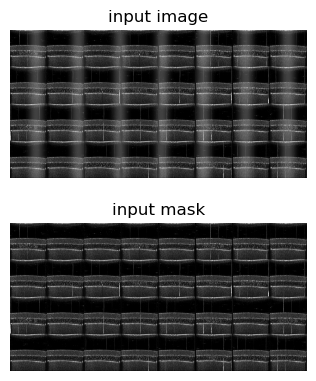

In [5]:
samples = next(iter(train_dataset_loader))

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 4))
fig.tight_layout()


ax1.axis('off')
ax1.set_title('input image')
ax1.imshow(np.transpose(vutils.make_grid(samples['img'], padding=2).numpy(),
                       (1, 2, 0)))

ax2.axis('off')
ax2.set_title('input mask')
ax2.imshow(np.transpose(vutils.make_grid(samples['mask'], padding=2).numpy(),
                       (1, 2, 0)), cmap='gray')

plt.show()

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        return out + x

class DerainingNetwork(nn.Module):
    def __init__(self, num_channels=3, num_blocks=2):
        super(DerainingNetwork, self).__init__()
        # self.guided_filter = GuidedFilter()
        print(num_channels)
        self.conv1 = nn.Conv2d(num_channels, 16, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.res_blocks = nn.ModuleList([ResidualBlock(16, 16) for _ in range(num_blocks)])
        self.conv2 = nn.Conv2d(16, num_channels, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        # detail = x - self.guided_filter(x, x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        for block in self.res_blocks:
            out = block(out)
        out = self.conv2(out)
        return x - out

model = DerainingNetwork(num_channels=1, num_blocks=2)

1


In [7]:
model

DerainingNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (res_blocks): ModuleList(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), paddi

In [8]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

In [9]:
# for i, sample in enumerate(train_dataset_loader):
#         input_rgb_tensor = sample['img'][0]
#         ina = sample['mask'][0]
#         print(ina.shape)
#         transforms.ToPILImage()(ina).show()
#         break

In [10]:
for epoch in range(num_epochs):
    for i, sample in enumerate(train_dataset_loader):
        input_rgb_tensor = sample['img']
        ina = sample['mask']
        # Forward pass
        outputs = model(input_rgb_tensor)
        loss = criterion(outputs, ina)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_dataset_loader), loss.item()))

# After training, run the model on the input tensor
# with torch.no_grad():
#     trained_output_tensor = model(input_rgb_tensor)

KeyboardInterrupt: 

In [ ]:
val_dataset[0]['img'].shape, val_dataset[0]['mask'].shape

(torch.Size([1, 224, 224]), torch.Size([1, 224, 224]))

In [ ]:
from torchvision import transforms
with torch.no_grad():
    trained_output_tensor = model(val_dataset[0]['img'].unsqueeze(0))
    transforms.ToPILImage()(trained_output_tensor.squeeze(0)).show()